In [1]:
from d2lnumpy import Accumulator
import d2lnumpy as d2l
from numpytorch.utils.data import DataLoader
import numpytorch.optim as optim
import numpytorch.nn as nn
import numpytorch as torch
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

num_batches = 32
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=num_batches)

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=3, padding=1),
    nn.ReLU(), nn.Conv2d(1, 1, kernel_size=3, padding=1),
    nn.ReLU(), nn.Conv2d(1, 1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(2),
    nn.Conv2d(1, 1, kernel_size=3, padding=1),
    nn.Flatten(),
    nn.Linear(49, 10)
)
# net = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2),
#     nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2),
#     nn.Flatten(),
#     nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
#     nn.Linear(120, 84), nn.Sigmoid(),
#     nn.Linear(84, 10))

net.layers[-1].weights = np.random.randn(10, 196) / 10
net.layers[-1].bias = np.zeros((1, 10))

X = np.zeros((1, 1, 28, 28), dtype=np.float32)
for layer in net.layers:
    X = layer.forward(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)
print(net)


Conv2d output shape: 	 (1, 1, 28, 28)
ReLU output shape: 	 (1, 1, 28, 28)
Conv2d output shape: 	 (1, 1, 28, 28)
ReLU output shape: 	 (1, 1, 28, 28)
Conv2d output shape: 	 (1, 1, 28, 28)
ReLU output shape: 	 (1, 1, 28, 28)
AvgPool2d output shape: 	 (1, 1, 14, 14)
Conv2d output shape: 	 (1, 1, 14, 14)
Flatten output shape: 	 (1, 196)
Linear output shape: 	 (1, 10)


In [3]:
def accuracy(y_hat, y):  # @save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y.reshape(-1)
    retval = float(cmp.astype(y.dtype).sum())
    return retval

In [4]:
def evaluate_accuracy(net, data_iter):  # @save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        pass  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net.forward(X), y), y.size)
    return metric[0] / metric[1]

In [5]:
def train_epoch_ch3(net, train_iter, loss, updater):  # @save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    # if isinstance(net, torch.nn.Module):
    #     net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    f = open('1.txt', 'a')

    for X, y in train_iter:
        # print(X.shape)
        y_hat = net.forward(X)

        # 这里 forward 就能进行前向传播，结果 mean 不 mean 无所谓
        l = loss.forward(y_pred=y_hat, y_true=y)
        grad = loss.backward(y_pred=y_hat, y_true=y)
        net.backward(grad)
        updater.step()

        # print('y_hat')
        # print(y_hat)
        # print('y')
        # print(y)
        # print(net.layers[1].dweights)

        # print('l.mean()')
        # print(l.mean())
        # print('--- l')
        # print(l)
        # print('--- ori')
        # ori_l = loss.forward(y_pred=y_hat, y_true=y)
        # print(ori_l)
        # raise KeyError
        # print(l.mean())

        # print timers
        f.write('forward timers: ')
        for i, layer in enumerate(net.layers):
            f.write(f'{i}:{net.f_timer[i]}|')
        f.write('\n')
        f.write('backward timers: ')
        for i, layer in enumerate(net.layers):
            f.write(f'{i} {net.b_timer[i]}|')
        f.write('\n')
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    f.close()
    return metric[0] / metric[2], metric[1] / metric[2]

In [6]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  # @save
    from d2lnumpy import Animator
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print('loss', train_metrics[0])
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    print('final epoch train_acc & test_acc: ', train_acc, test_acc)
    assert train_loss < 10, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [7]:
trainer = optim.SGD(net.layers, lr=0.1, batch_size=num_batches)
loss = nn.CrossEntropyLoss()

final epoch train_acc & test_acc:  0.09945 0.0999


AssertionError: 0.09945

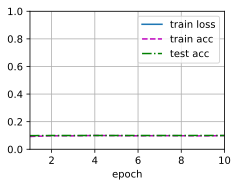

In [8]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

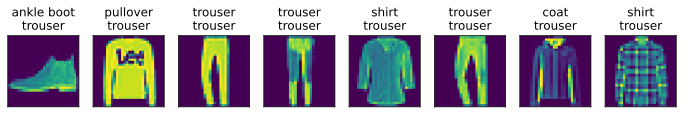

In [9]:
def predict_ch3(net, test_iter, n=8):  # @save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net.forward(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


predict_ch3(net, test_iter)